#### Libraries

In [1]:
!pip install numpy==1.19.3
!pip install mediapipe
import matplotlib.pyplot as plt
import mediapipe as mp
import pandas as pd
import numpy as np
import json
import cv2
import re
from PIL import Image
from google.colab.patches import cv2_imshow
from scipy.fft import fft, fftfreq
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.9 MB 5.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.3 which is incompatible.
tensorflow 2.8.0+zzzcolab20220506162203 requires numpy>=1.20, but you have numpy 1.19.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.4 MB/s 
Mounted at /content/drive


#### Functions

In [2]:
def get_facelandmarks_video(video_path):
    #Read a set of frames from the video.
    video_frames = cv2.VideoCapture(video_path)
    video_length = int(video_frames.get(cv2.CAP_PROP_FRAME_COUNT))
    #print(video_length)
    #Setup face mesh model object (there are several parameters pending for tuning up).
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    #Setup hand detector model.
    mp_hands = mp.solutions.hands
    hand_dect = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    frame_hand_found_init, frame_hand_found_end, once, count = 0, 0,0,0
    #Setup video saving properties.
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    #Output is prepared to receive input image rotated 90 degrees.
    name = str(video_path) + '_output.avi'
    out = cv2.VideoWriter(name, fourcc, 30.0, (210,350))

    total_landmarks_video_x, total_landmarks_video_y, total_landmarks_video_z = [], [], []

    for frames in range(video_length-2):

        landmark_frame_x, landmark_frame_y, landmark_frame_z, = [], [], []
        #Read a frame from set of frames.
        ret, face_image = video_frames.read()
        #Resize to standard size (right size still pending to validate)
        face_image = cv2.resize(face_image, (350, 210), interpolation=cv2.INTER_AREA)
        #Rotate 90 degrees.
        rotate_image = cv2.rotate(face_image, cv2.cv2.ROTATE_90_CLOCKWISE)
        #Get height and width of image for further calculations ahead (defined above).
        height, width, _ = rotate_image.shape
        #Convert the BGR image to RGB (required by library).
        rgb_image = cv2.cvtColor(rotate_image, cv2.COLOR_BGR2RGB)
         
        #Get facial landmarks from the image:
        result = face_mesh.process(rgb_image)
        #Get hand from the image:
        result_hand = hand_dect.process(rgb_image)

        if (result_hand.multi_hand_landmarks) and (once == 0):
          frame_hand_found_init = count
          once = 1
        elif(result_hand.multi_hand_landmarks) and (once == 1) and (count > frame_hand_found_init + 18000):
          #if a hand was found for a second time after 10 min (experiment aprox time) from founding the first one.
          frame_hand_found_end = count
        else:
          count = count + 1

       #If a Face has been recognized:
        if (result.multi_face_landmarks and result_hand.multi_hand_landmarks != True):

          #Only one face, first element.
          facial_landmarks = result.multi_face_landmarks[0]
          #The models generate 468 normalized [x,y,z] facial landmarks. 
          for i in range(len(facial_landmarks.landmark)):
              #Denormalize: multiply X coordinate by width and Y coordinate by height.
              x = int(facial_landmarks.landmark[i].x * width)
              y = int(facial_landmarks.landmark[i].y * height)
              #Save tuple of normalized (x,y) coordinates.
              landmark_frame_x.append(facial_landmarks.landmark[i].x)
              landmark_frame_y.append(facial_landmarks.landmark[i].y)
              landmark_frame_z.append(facial_landmarks.landmark[i].z)
              #Attach denormalize facial landmarks to frame.
              cv2.circle(rotate_image,(x,y),2,(100,100,0),-1)
   
          #Save each modified frame.  
          out.write(rotate_image)

          #Save lists of 468 facial landmarks from each frame.
          total_landmarks_video_x.append(landmark_frame_x)
          total_landmarks_video_y.append(landmark_frame_y)
          total_landmarks_video_z.append(landmark_frame_z)

        else: # fill with zero for frames where hand is found.
          total_landmarks_video_x.append([0] * 468)
          total_landmarks_video_y.append([0] * 468)
          total_landmarks_video_z.append([0] * 468)

    #print("Number of Frames: ",len(total_landmarks_video_x))
    #print("Number of Total Facial LandMarks - X coordinate: ",len(total_landmarks_video_x)*len(total_landmarks_video_x[0]))
    #print("Number of Total Facial LandMarks - Y coordinate: ",len(total_landmarks_video_y)*len(total_landmarks_video_y[0]))
    
    return total_landmarks_video_x, total_landmarks_video_y, total_landmarks_video_z, frame_hand_found_init, frame_hand_found_end

In [3]:
# Generate multivariate features with window_size from parallel sequences.
def generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample):
    coordinates = []
    i = 0
    while (i <= len(dataset_facelandmarks_x)-downsample-1):
        
        x_new, y_new, z_new = np.array(dataset_facelandmarks_x[i]), np.array(dataset_facelandmarks_y[i]), np.array(dataset_facelandmarks_z[i])
        
        for j in range(downsample-1):
            
            x_new = x_new + np.array(dataset_facelandmarks_x[(j+1)+i])
            y_new = y_new + np.array(dataset_facelandmarks_y[(j+1)+i])
            z_new = z_new + np.array(dataset_facelandmarks_z[(j+1)+i])
        
        i = i + downsample
        coordinates.append([x_new,y_new,z_new])
        
    return (np.array(coordinates)/downsample)

#### Generate FaceLandmarkPoints from Video - AUTOENCODER: ####

In [ ]:
##### TRAIN #####
n_samples = 4
downsample = 1
total_instances = []

for i in range(n_samples):
    # Change name of file to read.
    file_number = str(i+1)
    video_path = "/content/drive/MyDrive/AutoEncoder/Face_Videos_Train/Video_Face(" + file_number + ").MOV"
    # Read FaceLandmarks from Video.
    dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found_init, frame_hand_found_end = get_facelandmarks_video(video_path)
    print("Number of Frames in Video #" + str(file_number) + ": ", len(dataset_facelandmarks_x))
    print("Point Start Synchronization - Video #" + str(file_number) + ":", frame_hand_found_init)
    print("Point End Synchronization - Video #" + str(file_number) + ":", frame_hand_found_end)
    # Generate train features and target from windowing process.
    instance = generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample)
    np.save("/content/drive/MyDrive/AutoEncoder/FacePoints_numpy_Train/Video_Face_np("+ file_number +").npy", instance)


Number of Frames in Video #1:  18034
Point Start Synchronization - Video #1: 2873
Point End Synchronization - Video #1: 0
Number of Frames in Video #2:  17448
Point Start Synchronization - Video #2: 1098
Point End Synchronization - Video #2: 0
Number of Frames in Video #3:  22638
Point Start Synchronization - Video #3: 3483
Point End Synchronization - Video #3: 22476
Number of Frames in Video #4:  15368
Point Start Synchronization - Video #4: 0
Point End Synchronization - Video #4: 0


In [ ]:
##### TEST #####
n_samples = 1
downsample = 1
total_instances = []

for i in range(n_samples):
    # Change name of file to read.
    file_number = str(i+1)
    video_path = "/content/drive/MyDrive/AutoEncoder/Face_Videos_Test/Video_Face(" + file_number + ").MOV"
    # Read FaceLandmarks from Video.
    dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found_init, frame_hand_found_end = get_facelandmarks_video(video_path)
    print("Number of Frames in Video #" + str(file_number) + ": ", len(dataset_facelandmarks_x))
    print("Point Start Synchronization - Video #" + str(file_number) + ":", frame_hand_found_init)
    print("Point End Synchronization - Video #" + str(file_number) + ":", frame_hand_found_end)
    # Generate train features and target from windowing process.
    instance = generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample)
    np.save("/content/drive/MyDrive/AutoEncoder/FacePoints_numpy_Test/Video_Face_np("+ file_number +").npy", instance)

Number of Frames in Video #1:  1383
Point Start Synchronization - Video #1: 856
Point End Synchronization - Video #1: 0


#### Generate FaceLandmarkPoints from Video - With FaceShield (REGRESSOR): ####

In [ ]:
sync_dict = {
  "Person": ["David", "Daniel"],
  "Record": ["1","2"],
  "Init_Touch": [427,2],
  "End_Touch": [3098,2],
  "Init_Hand": [24,2],
  "End_Hand": [304,2]
}
sync_pd = pd.DataFrame.from_dict(sync_dict)

In [5]:
sync_dict = {
  "Person": ["David", "Daniel"],
  "Record": ["1","2"],
  "Init_Touch": [1677,2],
  "End_Touch": [7369,2],
  "Init_Hand": [5,2],
  "End_Hand": [605,2] #in seconds
}
sync_pd = pd.DataFrame.from_dict(sync_dict)

In [6]:
n_samples = 1
downsample = 3
total_instances = []

for i in range(n_samples):
    # Change name of file to read.
    file_number = str(i+1)
    video_path = "/content/drive/MyDrive/Regressor/FaceShield_Videos_Train/Video_FaceShield(" + file_number + ").MOV"
    # Read FaceLandmarks from Video.
    dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found_init, frame_hand_found_end = get_facelandmarks_video(video_path)
    print("Number of Frames in Video #" + str(file_number) + ": ", len(dataset_facelandmarks_x))
    print("Point Start Synchronization - Video #" + str(file_number) + ":", sync_pd.Init_Hand[0]*10)
    print("Point End Synchronization - Video #" + str(file_number) + ":", sync_pd.End_Hand[0]*10)
    # Generate train features and target from windowing process.
    instance = generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample)
    instance = instance[sync_pd.Init_Hand[0]*10:(sync_pd.End_Hand[0]*10)-1]
    np.save("/content/drive/MyDrive/Regressor/FaceShieldPoints_numpy_Train/Video_FaceShield_np("+ file_number +").npy", instance)
    print("Number of Frames in Video after 3 point Average #" + str(file_number) + ": ", len(instance))


Number of Frames in Video #1:  18180
Point Start Synchronization - Video #1: 50
Point End Synchronization - Video #1: 6050
Number of Frames in Video after 3 point Average #1:  5999


In [8]:
## Put capacitive data limit calculated in the Capacitive_Proce Notebook
instance2 = instance[0:5691]

In [11]:
np.save("/content/drive/MyDrive/Regressor/FaceShieldPoints_numpy_Train/Video_FaceShield_np("+ file_number +").npy", instance2)

In [ ]:
2799 - 2669
##Need to resample the capacitive data because it is not 10Hz exactly (thats why we get this difference) --> Use the timestamp from the json file.

130

In [ ]:
n_samples = 1
downsample = 3
total_instances = []

for i in range(n_samples):
    # Change name of file to read.
    file_number = str(i+1)
    video_path = "/content/drive/MyDrive/Regressor/FaceShield_Videos_Test/Video_FaceShield(" + file_number + ").MOV"
    # Read FaceLandmarks from Video.
    dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found_init, frame_hand_found_end = get_facelandmarks_video(video_path)
    print("Number of Frames in Video #" + str(file_number) + ": ", len(dataset_facelandmarks_x))
    print("Point Start Synchronization - Video #" + str(file_number) + ":", frame_hand_found_init)
    print("Point End Synchronization - Video #" + str(file_number) + ":", frame_hand_found_end)
    # Generate train features and target from windowing process.
    instance = generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample)
    np.save("/content/drive/MyDrive/Regressor/FaceShieldPoints_numpy_Test/Video_FaceShield_np("+ file_number +").npy", instance)
    print("Number of Frames in Video after 3 point Average #" + str(file_number) + ": ", len(instance))

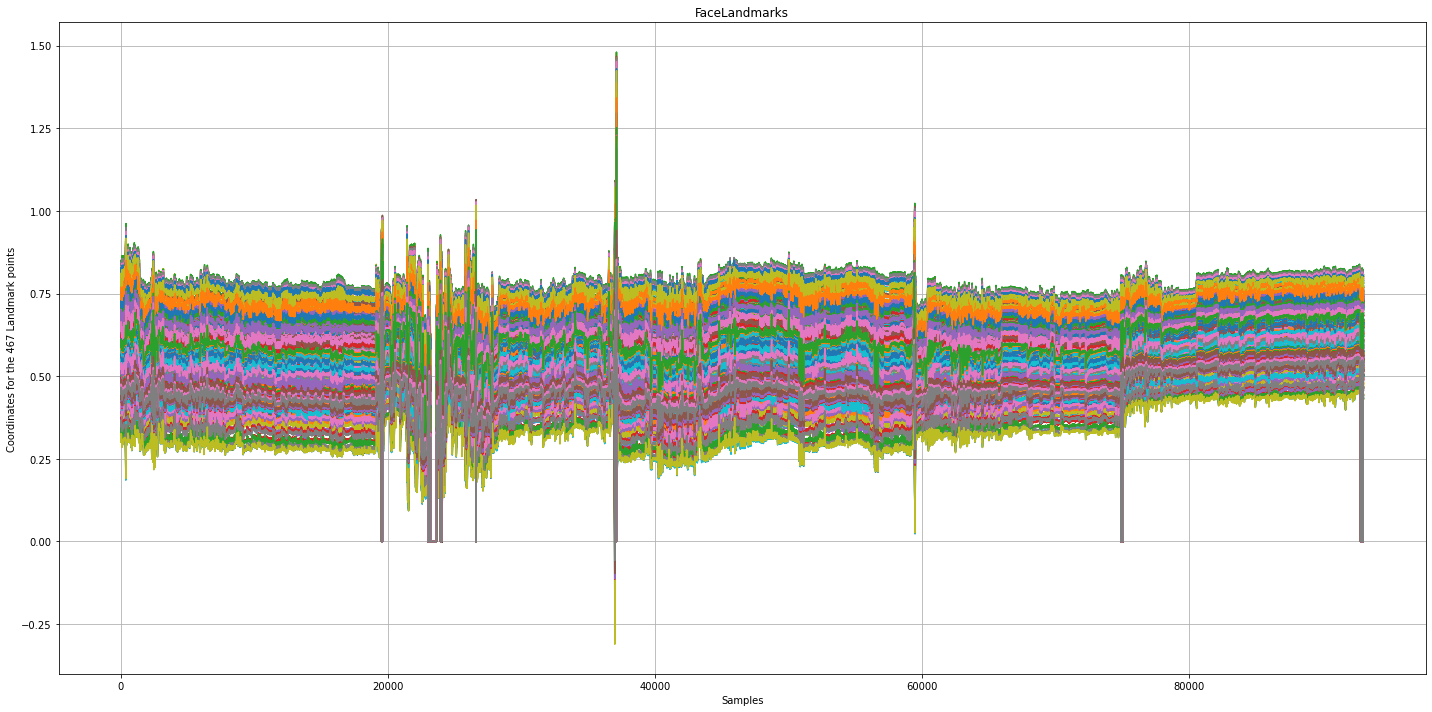

In [ ]:
points_x = total_instances_trans[:,:,0]
points_y = total_instances_trans[:,:,1]
#points_z = total_instances_trans[:,:,2]

plt.figure(figsize=(20,10))
#plt.plot(points_x)
plt.plot(points_y)
plt.title('FaceLandmarks')
plt.xlabel('Samples')
plt.ylabel('Coordinates for the 467 Landmark points')
plt.grid()
plt.show()